# Linear regression

Consider a simple linear regression with a single feature $x$, i.e.
\begin{equation}
y = ax + b + \epsilon,
\end{equation}
where $\epsilon$ is some form of noise.

## Data generation

First, let's generate some data. We have a feature $x$ with 100 data points, and labels $a=2$, $b=1$ with Gaussian noise $e$. We split our data to training and validation sets with 80:20 split.

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [21]:
np.random.seed(0)
x = np.random.rand(100, 1)
a = 1
b = 2
y = a*x + b + 0.1*np.random.randn(100, 1)

#shuffle indices
idx = np.arange(100)
np.random.shuffle(idx)

train_idx = idx[:80]
val_idx = idx[80:]

# training and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

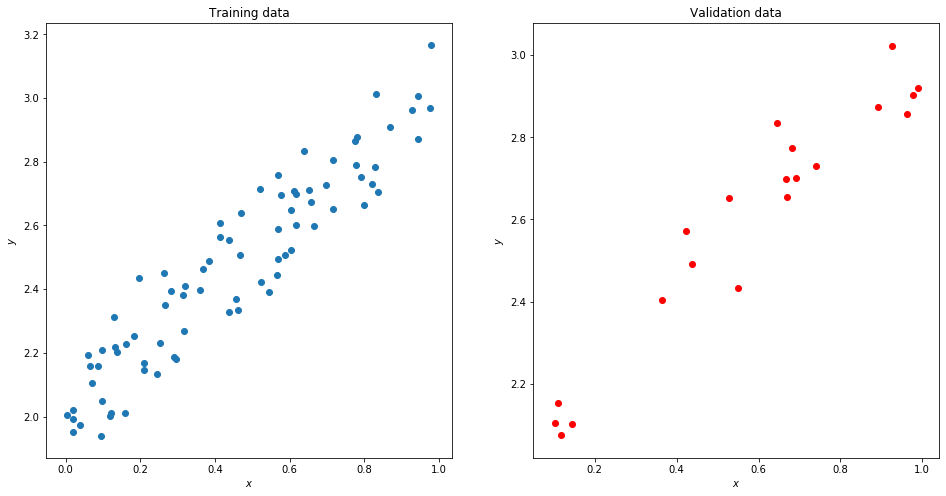

In [35]:
# plot the data
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].scatter(x_train, y_train)
ax[0].set_title("Training data")
ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$y$")

ax[1].scatter(x_val, y_val, color="r")
ax[1].set_title("Validation data")
ax[1].set_xlabel("$x$")
ax[1].set_ylabel("$y$")
plt.show()

## Linear regression in NumPy
Next, we implement a linear regression model in `NumPy` using MSE loss.

In [48]:
# initialize a and b randomly
np.random.seed(0)
a = np.random.randn(1)
b = np.random.randn(1)

print("a and b after initialization")
print(f"a={a.squeeze():.4f} b={b.squeeze():.4f}")

# set learning rate and and the number of epochs
lr = 0.1
epochs = 1000

for epoch in range(epochs):
    y_pred = a*x_train + b
    
    error = y_train - y_pred
    # MSE loss
    loss = np.mean(error**2)
    
    # compute gradients
    a_grad = -2*np.mean(x_train*error)
    b_grad = -2*np.mean(error)
    
    # update parameters
    a -= lr*a_grad
    b -= lr*b_grad

print()
print("a and b after gradient descent:")
print(f"a={a.squeeze():.4f} b={b.squeeze():.4f}")

a and b after initialization
a=1.7641 b=0.4002

a and b after gradient descent:
a=1.0044 b=2.0178


We can perform a sanity check with `LinearRegression` from `sklearn`.

In [55]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train)
intr, coeff = model.intercept_, model.coef_[0]

print(f"coefficient={coeff.squeeze():.4f} intercept={intr.squeeze():.4f}")

coefficient=1.0044 intercept=2.0179


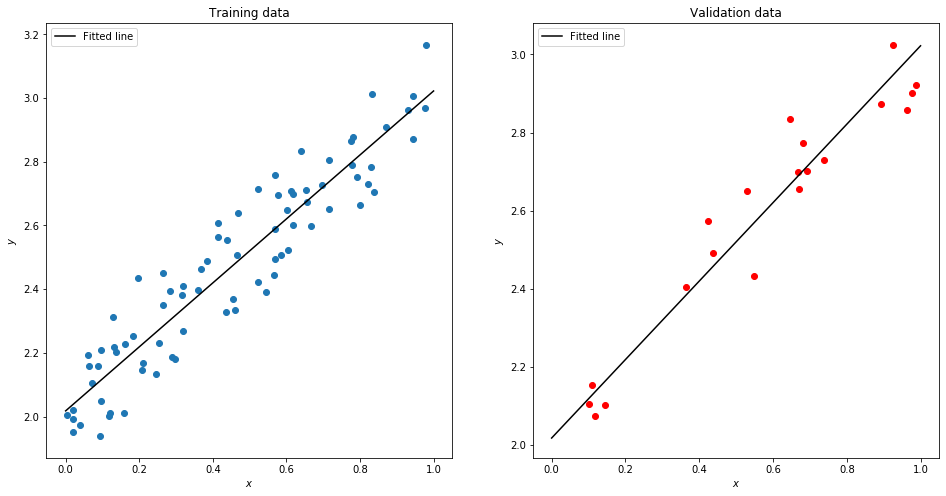

In [60]:
# plot the fitted line
x_plot = np.linspace(0, 1, 100)
y_plot = a*x_plot + b

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].scatter(x_train, y_train)
ax[0].set_title("Training data")
ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$y$")
ax[0].plot(x_plot, y_plot, color="black", label="Fitted line")
ax[0].legend()

ax[1].scatter(x_val, y_val, color="r")
ax[1].set_title("Validation data")
ax[1].set_xlabel("$x$")
ax[1].set_ylabel("$y$")
ax[1].plot(x_plot, y_plot, color="black", label="Fitted line")
ax[1].legend()
plt.show()

Seems to work well.

# PyTorch
Make the required imports, change the data to `PyTorch` tensors and send them to GPU (if available).

In [64]:
import torch
import torch.optim as optim
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

print(type(x_train), type(x_train_tensor), x_train_tensor.type())

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.cuda.FloatTensor


## Creating parameters
Let's then create the parameters $a$ and $b$. The trainable parameters require computation of their **gradients**, so that their values can be updated. Therefore we set `requires_grad=True`. Furthermore, we create the parameter tensors directly on the device memory.

In [66]:
torch.manual_seed(0)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

tensor([-0.9247], device='cuda:0', requires_grad=True) tensor([0.1808], device='cuda:0', requires_grad=True)


## Autograd
`Autograd` is `PyTorch`'s automatic differentiation package, such that the gradients need not be computed manually. To compute the gradients w.r.t. the loss function, we need to invoke `backward()` method of the corresponding variable, e.g. `loss.backward()`. The gradients are **accumulated**, so every time they are used to update the parameters, the gradients need to be zeroed afterwards. This is accomplished with `zero_()`. The underscore stands for **in-place**.

In [71]:
lr = 0.1
epochs = 1000

torch.manual_seed(0)

a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

for epoch in range(epochs):
    y_pred = a*x_train_tensor + b
    error = y_train_tensor - y_pred
    loss = (error**2).mean()
    
    # no more manual computation of gradients
    loss.backward()
    
    #print(a.grad)
    #print(b.grad)
    
    with torch.no_grad():
        a -= lr*a.grad
        b -= lr*b.grad
        
    a.grad.zero_()
    b.grad.zero_()
    
print(a, b)

tensor([-0.9247], device='cuda:0', requires_grad=True) tensor([0.1808], device='cuda:0', requires_grad=True)
tensor([1.0044], device='cuda:0', requires_grad=True) tensor([2.0179], device='cuda:0', requires_grad=True)


We obtain the same results as before with `NumPy` and `sklearn`. The `torch.no_grad()` allows us to perform regular `Python` operations on tensors, independent of `PyTorch`'s computation graph.

## Optimizer
Thus far the parameters have been updated manually, but there's a better way. An optimizer takes the parameters to be updated, the learning rate (and other hyperparameters as well), and performs the updates via its `step()` method. In addition, the gradients need not be zeroed out one by one anymore. This is accomplished by the optimizer's `zero_grad()` method. Next, we will use SGD optimizer to update the parameters $a$ and $b$.

In [73]:
lr = 0.1
epochs = 1000

torch.manual_seed(0)

a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

# SGD optimizer
optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(epochs):
    y_pred = a*x_train_tensor + b
    error = y_train_tensor - y_pred
    loss = (error**2).mean()
    
    loss.backward()
    
    optimizer.step()
        
    optimizer.zero_grad()
    
print(a, b)

tensor([-0.9247], device='cuda:0', requires_grad=True) tensor([0.1808], device='cuda:0', requires_grad=True)
tensor([1.0044], device='cuda:0', requires_grad=True) tensor([2.0179], device='cuda:0', requires_grad=True)


## Loss
Next we move on to the computation of the loss function. In this case we use the `PyTorch` implementation of MSE loss, which is only one of many options.

> Note that `nn.MSELoss()` creates a loss function, it is **not** the loss function itself.

In [75]:
lr = 0.1
epochs = 1000

torch.manual_seed(0)

a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

optimizer = optim.SGD([a, b], lr=lr)
# loss function
loss_fn = nn.MSELoss(reduction="mean")

for epoch in range(epochs):
    y_pred = a*x_train_tensor + b
    loss = loss_fn(y_train_tensor, y_pred)
    
    loss.backward()
    
    optimizer.step()
        
    optimizer.zero_grad()
    
print(a, b)

tensor([-0.9247], device='cuda:0', requires_grad=True) tensor([0.1808], device='cuda:0', requires_grad=True)
tensor([1.0044], device='cuda:0', requires_grad=True) tensor([2.0179], device='cuda:0', requires_grad=True)


## Model
A `PyTorch` model is represented as a regular `Python` class that inherits from the `Module` class. It needs to implement 
- `__init__(self)`: defines the parts that make up the model, here the parameters $a$ and $b$.
- `forward(self, x)`: performs the actual computation, i.e. outputs a prediction given input $x$. 

> However, the `forward(x)` method should not be called. The whole model should be called instead, i.e. `model(x)`.

Let's build a simple model for our linear regression task.

In [80]:
class LinearRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        # the parameters need to be wrapped inside nn.Parameter
        self.a = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
    
    def forward(self, x):
        return self.a*x + self.b

In the `__init__()` method we used the `Parameter()` class to define the parameters $a$ and $b$ in order to tell `PyTorch` that these tensors should be considered parameters of the model they are an attribute of. This allows us to use our model's `parameters()` method to retrieve an iterator over the parameters of the model, which can be then fed to the optimizer, so that we need not to build the list of parameters manually. Furthermore, the current values of all parameters can be obtained using the `state_dict()` method.

> **Important**: The model needs to be sent to the same device where the data resides.

The modified code then looks as follows.

In [82]:
lr = 0.1
epochs = 1000

torch.manual_seed(0)

# create a model and send it to device
model = LinearRegressor().to(device)
print(model.state_dict())

optimizer = optim.SGD(model.parameters(), lr=lr)
# loss function
loss_fn = nn.MSELoss(reduction="mean")

for epoch in range(epochs):
    model.train()
    
    y_pred = model(x_train_tensor)
    
    loss = loss_fn(y_train_tensor, y_pred)
    
    loss.backward()
    
    optimizer.step()
        
    optimizer.zero_grad()
    
print(model.state_dict())

OrderedDict([('a', tensor([1.5410], device='cuda:0')), ('b', tensor([-0.2934], device='cuda:0'))])
OrderedDict([('a', tensor([1.0044], device='cuda:0')), ('b', tensor([2.0178], device='cuda:0'))])


The model's `train()` method does **not** perform a training step, but is used to set the model to **training mode**. Some models may use mechanisms, e.g. dropout, which behave distinctly different in training versus in evaluation.